In [1]:
import torch
import torch.nn as nn
import scipy.io as sio
import matplotlib.pyplot as plt
import tqdm
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Dataset
import random

from network import OlshausenField1996Model

from pydeep.preprocessing import ICA, ZCA
import pydeep.misc.io as io
import pydeep.misc.visualization as vis
import argparse

e:\Anaconda Revive\lib\site-packages\pydeep-1.2.0-py3.9.egg\pydeep\misc\io.py:417: SyntaxWarning: "is" with a literal. Did you mean "=="?
e:\Anaconda Revive\lib\site-packages\pydeep-1.2.0-py3.9.egg\pydeep\misc\io.py:417: SyntaxWarning: "is" with a literal. Did you mean "=="?
e:\Anaconda Revive\lib\site-packages\pydeep-1.2.0-py3.9.egg\pydeep\misc\visualization.py:244: SyntaxWarning: "is" with a literal. Did you mean "=="?
e:\Anaconda Revive\lib\site-packages\pydeep-1.2.0-py3.9.egg\pydeep\misc\visualization.py:252: SyntaxWarning: "is" with a literal. Did you mean "=="?
e:\Anaconda Revive\lib\site-packages\pydeep-1.2.0-py3.9.egg\pydeep\misc\visualization.py:345: SyntaxWarning: "is" with a literal. Did you mean "=="?
e:\Anaconda Revive\lib\site-packages\pydeep-1.2.0-py3.9.egg\pydeep\misc\visualization.py:347: SyntaxWarning: "is" with a literal. Did you mean "=="?
e:\Anaconda Revive\lib\site-packages\pydeep-1.2.0-py3.9.egg\pydeep\misc\visualization.py:244: SyntaxWarning: "is" with a literal

### Vanilla ###

In [2]:
# parser = argparse.ArgumentParser(description='Olshausen Field 1996 Model Parameters')
# parser.add_argument('--imgsize', type=int, default=9, help='Image patch size')
# parser.add_argument('--n_units', type=int, default=100, help='Number of units in the model')
# parser.add_argument('--n_iters', type=int, default=500, help='Number of iterations for training')
# parser.add_argument('--batch_size', type=int, default=256, help='Batch size')
# parser.add_argument('--repeat_factor', type=int, default=500, help='Repeat factor for dataset')

# args = parser.parse_args()

# imgsize = args.imgsize
# n_units = args.n_units
# n_iters = args.n_iters
# repeat_factor = args.repeat_factor
# batch_size = args.batch_size

In [3]:
imgsize = 9
batch_size = 256
n_units = 100
n_iters = 500
n_samples = n_iters * batch_size
early_stopping = True
nt_max = 1000
device='cpu'

(128256, 81)


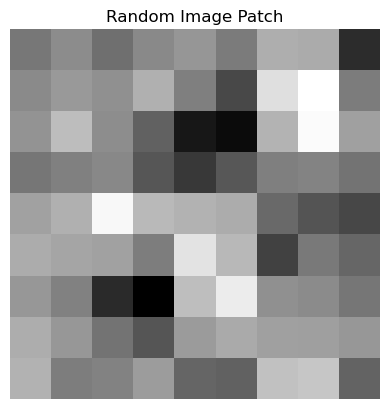

In [4]:
#load base data
#Data from OlshausenField 1996 -> centered but not normalized/random cropped/9x9 patches

data = np.load('.\patches\patches.npy').squeeze().reshape(-1,81)
print(data.shape)

random_idx = random.randint(0, data.shape[0] - 1)
plt.imshow(data[random_idx].reshape(imgsize, imgsize), cmap='gray')
plt.title('Random Image Patch')
plt.axis('off')
plt.show()


In [ ]:
#Olshausen
dataloader_olhausen = DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
print(len(dataloader_olhausen))

#ZCA whitening for ICA method
zca = ZCA(input_dim=imgsize**2)
zca.train(data=data)

# ZCA projects the whitened data back to the original space, thus does not
# perform a dimensionality reduction but a whitening in the original space
whitened_data = zca.project(data)
#whitened_data=data


501


In [6]:
def train_olshausen(model, dataloader, n_iters, eps, early_stopping=True, nt_max=1000, collect_data_for_ICA=False):
    # Run simulation
    error_list = [] # List to save errors
    if collect_data_for_ICA: #ICA method requires whole batch of data
        ica_data = []
    for n, imgs in tqdm.tqdm(enumerate(dataloader)):

        inputs = imgs
        if collect_data_for_ICA:
            ica_data.append(inputs)
        if inputs.shape[1] != imgsize**2:
            print("Not correct size:", inputs.shape[1], imgsize**2)
            continue  # Skip if image size is not correct

        model.initialize_states() # Reset states
        model.normalize_rows() # Normalize weights
        
        # Input an image patch until latent variables are converged 
        r_tm1 = model.r # set previous r (t minus 1)

        for t in range(nt_max):
            # Update r without update weights 
            error, r = model(inputs, training=False)
            dr = r - r_tm1 

            # Compute norm of r
            dr_norm = torch.norm(dr) / (eps + torch.norm(r_tm1))
            r_tm1 = r # update r_tm1
            
            # Check convergence of r, then update weights
            if dr_norm < eps:
                error, r = model(inputs, training=True)
                break
            
            # If failure to convergence, break and print error
            if t >= nt_max-2: 
                print("Error at patch:", n)
                print(dr_norm)
                break
    
        error_list.append(model.calculate_total_error(error)) # Append errors

        # Print moving average error
        if n % 100 == 99:  
            print("iter: "+str(n+1)+"/"+str(n_iters)+", Moving error:",
                torch.mean(torch.stack(error_list[n-99:n])))
        
        if early_stopping and n >= n_iters:
            break
    
    if collect_data_for_ICA:
        return torch.flatten(torch.stack(ica_data), start_dim=0,end_dim=1).numpy(), error_list
    return error_list


In [7]:
eps = 1e-2 # small value which determines convergence
error_list = [] # List to save errors
olshausen_vanilla = OlshausenField1996Model(num_inputs=imgsize**2, num_units=n_units, batch_size=batch_size, device=device)

error_list = train_olshausen(olshausen_vanilla, dataloader_olhausen, n_iters, eps, early_stopping=early_stopping, nt_max=nt_max)


112it [00:02, 59.84it/s]

iter: 100/500, Moving error: tensor(0.0413)


210it [00:03, 62.54it/s]

iter: 200/500, Moving error: tensor(0.0355)


308it [00:05, 66.02it/s]

iter: 300/500, Moving error: tensor(0.0349)


408it [00:06, 66.36it/s]

iter: 400/500, Moving error: tensor(0.0347)


500it [00:08, 61.69it/s]

iter: 500/500, Moving error: tensor(0.0342)


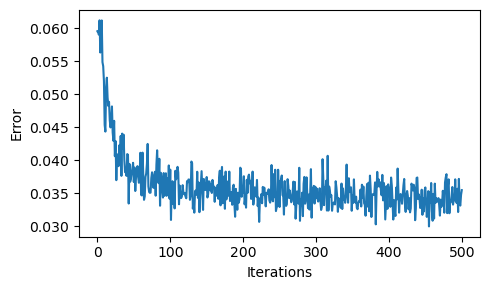

In [8]:
# Plot error
plt.figure(figsize=(5, 3))
plt.ylabel("Error")
plt.xlabel("Iterations")
plt.plot(np.arange(len(error_list)), torch.stack(error_list).cpu())
plt.tight_layout()
plt.show()

100%|██████████| 100/100 [00:00<00:00, 115.38it/s]


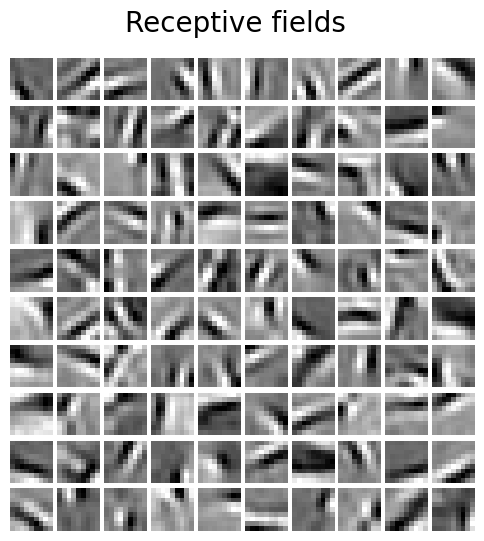

In [9]:
# Plot Receptive fields
fig = plt.figure(figsize=(6, 6))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in tqdm.tqdm(range(n_units)):
    plt.subplot(10, 10, i+1)
    plt.imshow(np.reshape(olshausen_vanilla.Phi[:, i].cpu(), (imgsize, imgsize)), cmap="gray")
    plt.axis("off")

fig.suptitle("Receptive fields", fontsize=20)
plt.subplots_adjust(top=0.9)
plt.show()

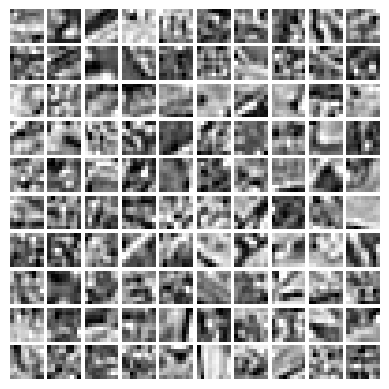

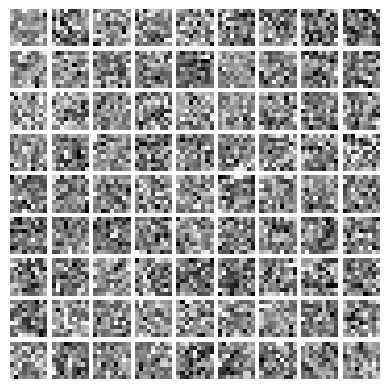

In [10]:
#ICA
ica = ICA(input_dim=imgsize**2)
ica.train(data=whitened_data,
          iterations=100,
          convergence=1.0,
          status=False)

# Show images
images = vis.tile_matrix_rows(matrix=data[0:100].T,
                              tile_width=imgsize,
                              tile_height=imgsize,
                              num_tiles_x=10,
                              num_tiles_y=10,
                              border_size=1,
                              normalized=True)
vis.imshow_matrix(matrix=images,
                  windowtitle='First 100 image patches')

# # Show some whitened images
# images = vis.tile_matrix_rows(matrix=whitened_data[0:100].T,
#                               tile_width=imgsize,
#                               tile_height=imgsize,
#                               num_tiles_x=10,
#                               num_tiles_y=10,
#                               border_size=1,
#                               normalized=True)
# vis.imshow_matrix(matrix=images,
#                   windowtitle='First 100 image patches whitened')

# Show the ICA filters/bases
ica_filters = vis.tile_matrix_rows(matrix=ica.projection_matrix,
                                   tile_width=imgsize,
                                   tile_height=imgsize,
                                   num_tiles_x=imgsize,
                                   num_tiles_y=imgsize,
                                   border_size=1,
                                   normalized=True)
vis.imshow_matrix(matrix=ica_filters,
                  windowtitle='Filters learned by ICA')

vis.show()

In [7]:
from distortion import contrast_alpha, add_gaussian_noise, blur_beta_pool, Normalize01

### Distortion Type I: Contrast ###

501


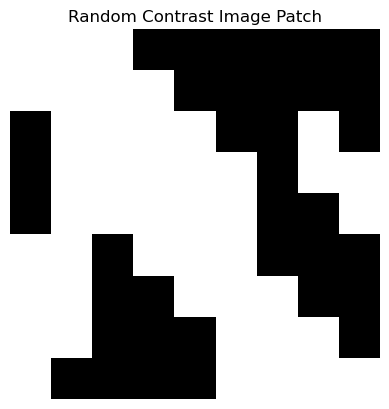

In [ ]:
#Contrast param: alpha, 1 for no change, 0 for gray image, 10 for binary image
alpha=10

#Olshausen
transform_contrast = transforms.Compose([
    transforms.ToTensor(),
    contrast_alpha(alpha=alpha),
])

class dataset_contrast(Dataset):
    def __init__(self, patches, transform=None):
        self.patches = patches
        self.transform = transform

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        img = self.patches[idx].reshape(imgsize, imgsize)

        if self.transform is not None:
            img = self.transform(img)
        return img.view(-1)

data_contrast = dataset_contrast(data, transform=transform_contrast)
dataloader_olhausen_contrast = DataLoader(data_contrast, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
print(len(dataloader_olhausen_contrast))

random_idx = random.randint(0, len(data_contrast) - 1)
img = data_contrast[random_idx].numpy().reshape(imgsize, imgsize)
plt.imshow(img, cmap='gray')
plt.title('Random Contrast Image Patch')
plt.axis('off')
plt.show()

In [19]:
eps = 1e-2 # small value which determines convergence
olshausen_contrast = OlshausenField1996Model(num_inputs=imgsize**2, num_units=n_units, batch_size=batch_size, device=device)

data_ica_contrast, error_list = train_olshausen(olshausen_contrast,
                                                dataloader_olhausen_contrast,
                                                n_iters,
                                                eps,
                                                early_stopping=early_stopping,
                                                nt_max=nt_max,
                                                collect_data_for_ICA=True)

103it [00:03, 28.21it/s]

iter: 100/500, Moving error: tensor(0.1434)


204it [00:07, 29.05it/s]

iter: 200/500, Moving error: tensor(0.1388)


302it [00:10, 27.87it/s]

iter: 300/500, Moving error: tensor(0.1379)


405it [00:14, 29.67it/s]

iter: 400/500, Moving error: tensor(0.1375)


500it [00:17, 28.81it/s]

iter: 500/500, Moving error: tensor(0.1371)


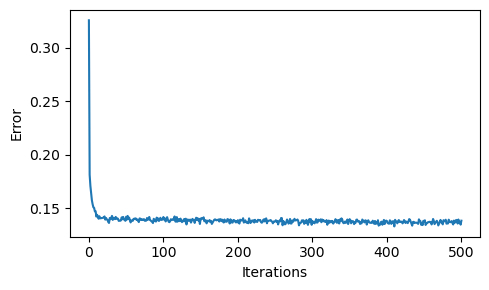

In [20]:
# Plot error
plt.figure(figsize=(5, 3))
plt.ylabel("Error")
plt.xlabel("Iterations")
plt.plot(np.arange(len(error_list)), torch.stack(error_list).cpu())
plt.tight_layout()
plt.show()

100%|██████████| 100/100 [00:01<00:00, 92.23it/s]


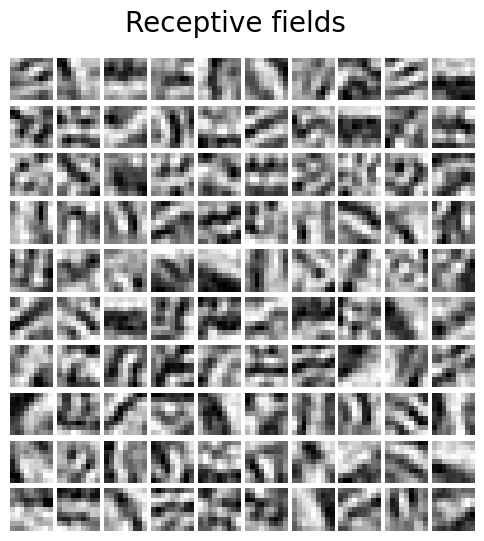

In [21]:
# Plot Receptive fields
fig = plt.figure(figsize=(6, 6))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in tqdm.tqdm(range(n_units)):
    plt.subplot(10, 10, i+1)
    plt.imshow(np.reshape(olshausen_contrast.Phi[:, i].cpu(), (imgsize, imgsize)), cmap="gray")
    plt.axis("off")

fig.suptitle("Receptive fields", fontsize=20)
plt.subplots_adjust(top=0.9)
plt.show()

In [22]:
#ZCA whitening for ICA method
zca = ZCA(input_dim=imgsize**2)
zca.train(data=data_ica_contrast)

# ZCA projects the whitened data back to the original space, thus does not
# perform a dimensionality reduction but a whitening in the original space
whitened_data_contrast = zca.project(data_ica_contrast)


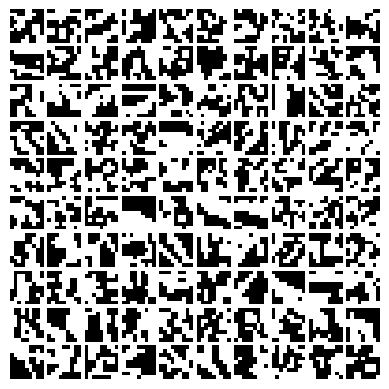

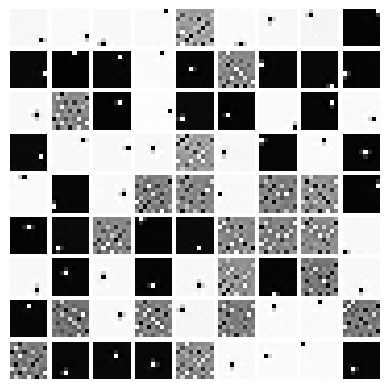

In [23]:
#ICA
ica_contrast = ICA(input_dim=imgsize**2)
ica_contrast.train(data=whitened_data_contrast,
          iterations=100,
          convergence=1.0,
          status=False)

# Show images
images = vis.tile_matrix_rows(matrix=data_ica_contrast[0:100].T,
                              tile_width=imgsize,
                              tile_height=imgsize,
                              num_tiles_x=10,
                              num_tiles_y=10,
                              border_size=1,
                              normalized=True)
vis.imshow_matrix(matrix=images,
                  windowtitle='First 100 image patches')

# # Show some whitened images
# images = vis.tile_matrix_rows(matrix=whitened_data[0:100].T,
#                               tile_width=imgsize,
#                               tile_height=imgsize,
#                               num_tiles_x=10,
#                               num_tiles_y=10,
#                               border_size=1,
#                               normalized=True)
# vis.imshow_matrix(matrix=images,
#                   windowtitle='First 100 image patches whitened')

# Show the ICA filters/bases
ica_filters_contrast = vis.tile_matrix_rows(matrix=ica_contrast.projection_matrix,
                                   tile_width=imgsize,
                                   tile_height=imgsize,
                                   num_tiles_x=imgsize,
                                   num_tiles_y=imgsize,
                                   border_size=1,
                                   normalized=True)
vis.imshow_matrix(matrix=ica_filters_contrast,
                  windowtitle='Filters learned by ICA')

vis.show()

### Distortion Type II: Noise ###

501


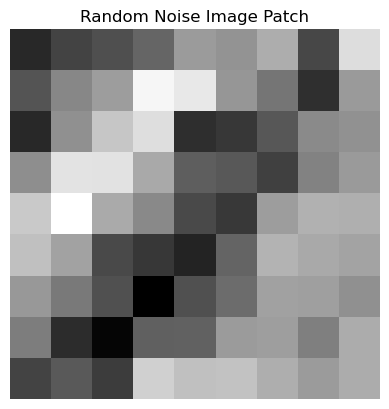

In [28]:
#Noise param: sigma, 0~inf
sigma=0.5 #>=0

#Olshausen
transform_noise = transforms.Compose([
    transforms.ToTensor(),
    add_gaussian_noise(sigma=sigma),
])

class dataset_noise(Dataset):
    def __init__(self, patches, transform=None):
        self.patches = patches
        self.transform = transform

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        img = self.patches[idx].reshape(imgsize, imgsize)

        if self.transform is not None:
            img = self.transform(img)
        return img.view(-1)

data_noise = dataset_noise(data, transform=transform_noise)
dataloader_olhausen_noise = DataLoader(data_noise, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
print(len(dataloader_olhausen_noise))

random_idx = random.randint(0, len(data_noise) - 1)
img = data_noise[random_idx].numpy().reshape(imgsize, imgsize)
plt.imshow(img, cmap='gray')
plt.title('Random Noise Image Patch')
plt.axis('off')
plt.show()

In [29]:
eps = 1e-2 # small value which determines convergence
olshausen_noise = OlshausenField1996Model(num_inputs=imgsize**2, num_units=n_units, batch_size=batch_size, device=device)

data_ica_noise, error_list = train_olshausen(olshausen_noise,
                                             dataloader_olhausen_noise,
                                             n_iters,
                                             eps,
                                             early_stopping=early_stopping,
                                             nt_max=nt_max,
                                             collect_data_for_ICA=True)

107it [00:03, 35.47it/s]

iter: 100/500, Moving error: tensor(0.0540)


203it [00:05, 34.78it/s]

iter: 200/500, Moving error: tensor(0.0495)


307it [00:08, 35.94it/s]

iter: 300/500, Moving error: tensor(0.0492)


403it [00:11, 35.61it/s]

iter: 400/500, Moving error: tensor(0.0488)


500it [00:14, 35.02it/s]

iter: 500/500, Moving error: tensor(0.0479)


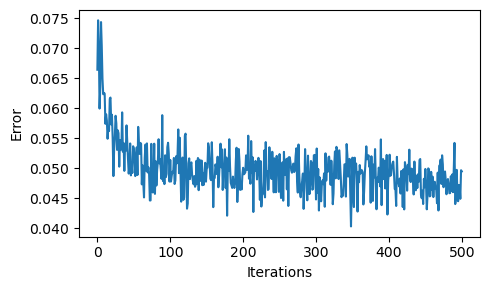

In [30]:
# Plot error
plt.figure(figsize=(5, 3))
plt.ylabel("Error")
plt.xlabel("Iterations")
plt.plot(np.arange(len(error_list)), torch.stack(error_list).cpu())
plt.tight_layout()
plt.show()

100%|██████████| 100/100 [00:00<00:00, 105.54it/s]


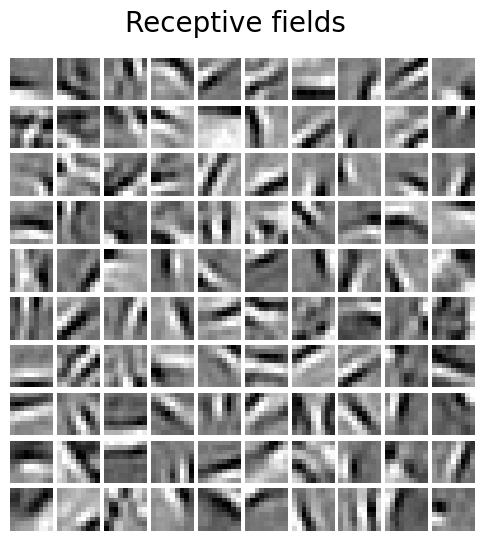

In [31]:
# Plot Receptive fields
fig = plt.figure(figsize=(6, 6))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in tqdm.tqdm(range(n_units)):
    plt.subplot(10, 10, i+1)
    plt.imshow(np.reshape(olshausen_noise.Phi[:, i].cpu(), (imgsize, imgsize)), cmap="gray")
    plt.axis("off")

fig.suptitle("Receptive fields", fontsize=20)
plt.subplots_adjust(top=0.9)
plt.show()

In [32]:
#ZCA whitening for ICA method
zca = ZCA(input_dim=imgsize**2)
zca.train(data=data_ica_noise)

# ZCA projects the whitened data back to the original space, thus does not
# perform a dimensionality reduction but a whitening in the original space
whitened_data_noise = zca.project(data_ica_noise)


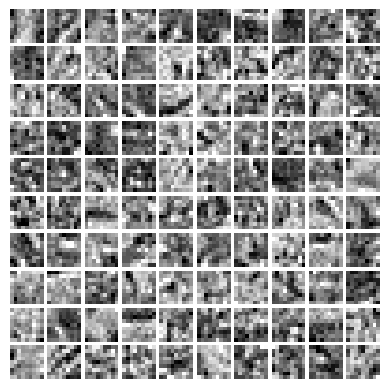

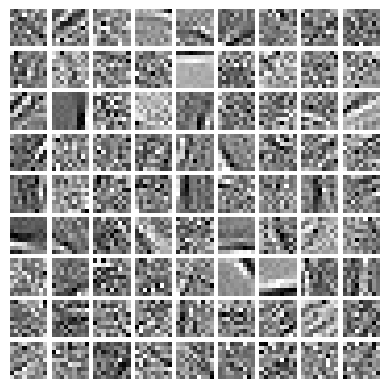

In [33]:
#ICA
ica_noise = ICA(input_dim=imgsize**2)
ica_noise.train(data=whitened_data_noise,
          iterations=100,
          convergence=1.0,
          status=False)

# Show images
images = vis.tile_matrix_rows(matrix=data_ica_noise[0:100].T,
                              tile_width=imgsize,
                              tile_height=imgsize,
                              num_tiles_x=10,
                              num_tiles_y=10,
                              border_size=1,
                              normalized=True)
vis.imshow_matrix(matrix=images,
                  windowtitle='First 100 image patches')

# # Show some whitened images
# images = vis.tile_matrix_rows(matrix=whitened_data[0:100].T,
#                               tile_width=imgsize,
#                               tile_height=imgsize,
#                               num_tiles_x=10,
#                               num_tiles_y=10,
#                               border_size=1,
#                               normalized=True)
# vis.imshow_matrix(matrix=images,
#                   windowtitle='First 100 image patches whitened')

# Show the ICA filters/bases
ica_filters_noise = vis.tile_matrix_rows(matrix=ica_noise.projection_matrix,
                                   tile_width=imgsize,
                                   tile_height=imgsize,
                                   num_tiles_x=imgsize,
                                   num_tiles_y=imgsize,
                                   border_size=1,
                                   normalized=True)
vis.imshow_matrix(matrix=ica_filters_noise,
                  windowtitle='Filters learned by ICA')

vis.show()

### Distortion Type III: Blur ###

501


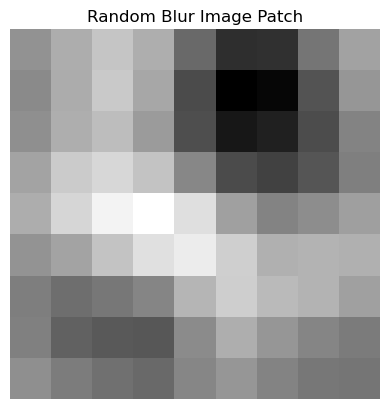

In [17]:
#Blur param: beta, effect kernel size non-linearly, not that impactful
#beta<2.2: nochange, 2.2<beta<6.6: mild blur, 6.6<beta<11.1: strong blur, beta>11.1, heavy blur
beta=5 #>=0

#Olshausen
transform_blur = transforms.Compose([
    transforms.ToTensor(),
    blur_beta_pool(beta=beta),
])

class dataset_blur(Dataset):
    def __init__(self, patches, transform=None):
        self.patches = patches
        self.transform = transform

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        img = self.patches[idx].reshape(imgsize, imgsize)

        if self.transform is not None:
            img = self.transform(img)
        return img.view(-1)

data_blur = dataset_blur(data, transform=transform_blur)
dataloader_olhausen_blur = DataLoader(data_blur, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
print(len(dataloader_olhausen_blur))

random_idx = random.randint(0, len(data_blur) - 1)
img = data_blur[random_idx].reshape(imgsize, imgsize)
plt.imshow(img, cmap='gray')
plt.title('Random Blur Image Patch')
plt.axis('off')
plt.show()

In [18]:
eps = 1e-2 # small value which determines convergence
olshausen_blur = OlshausenField1996Model(num_inputs=imgsize**2, num_units=n_units, batch_size=batch_size, device=device)

data_ica_blur, error_list = train_olshausen(olshausen_blur,
                                             dataloader_olhausen_blur,
                                             n_iters,
                                             eps,
                                             early_stopping=early_stopping,
                                             nt_max=nt_max,
                                             collect_data_for_ICA=True)

104it [00:02, 45.46it/s]

iter: 100/500, Moving error: tensor(0.0149)


205it [00:04, 46.94it/s]

iter: 200/500, Moving error: tensor(0.0116)


307it [00:06, 47.21it/s]

iter: 300/500, Moving error: tensor(0.0110)


405it [00:08, 47.87it/s]

iter: 400/500, Moving error: tensor(0.0104)


500it [00:10, 46.30it/s]

iter: 500/500, Moving error: tensor(0.0103)


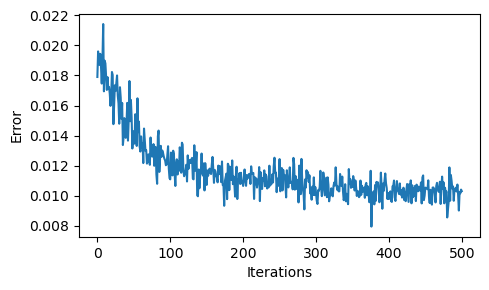

In [19]:
# Plot error
plt.figure(figsize=(5, 3))
plt.ylabel("Error")
plt.xlabel("Iterations")
plt.plot(np.arange(len(error_list)), torch.stack(error_list).cpu())
plt.tight_layout()
plt.show()

100%|██████████| 100/100 [00:00<00:00, 100.33it/s]


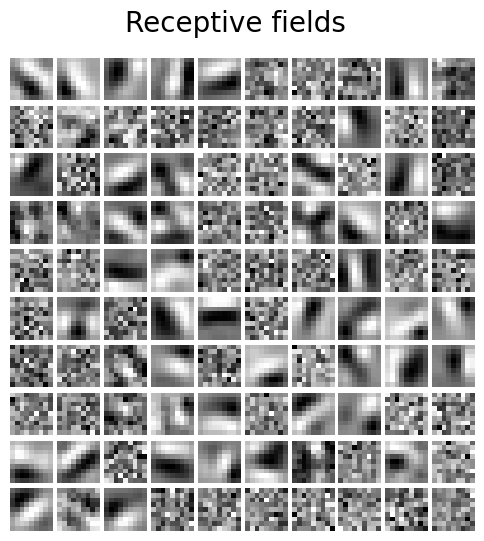

In [20]:
# Plot Receptive fields
fig = plt.figure(figsize=(6, 6))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in tqdm.tqdm(range(n_units)):
    plt.subplot(10, 10, i+1)
    plt.imshow(np.reshape(olshausen_blur.Phi[:, i].cpu(), (imgsize, imgsize)), cmap="gray")
    plt.axis("off")

fig.suptitle("Receptive fields", fontsize=20)
plt.subplots_adjust(top=0.9)
plt.show()

In [21]:
#ZCA whitening for ICA method
zca = ZCA(input_dim=imgsize**2)
zca.train(data=data_ica_blur)

# ZCA projects the whitened data back to the original space, thus does not
# perform a dimensionality reduction but a whitening in the original space
whitened_data_blur = zca.project(data_ica_blur)


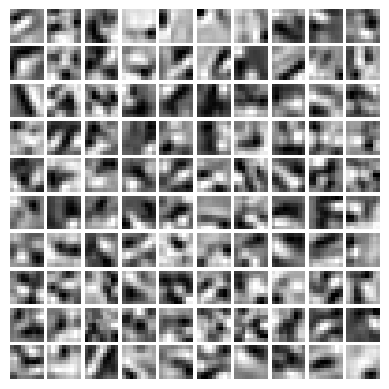

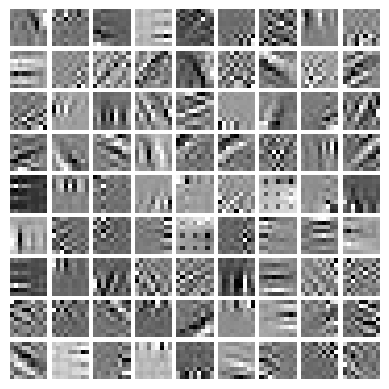

In [22]:
#ICA
ica_blur = ICA(input_dim=imgsize**2)
ica_blur.train(data=whitened_data_blur,
          iterations=100,
          convergence=1.0,
          status=False)

# Show images
images = vis.tile_matrix_rows(matrix=data_ica_blur[0:100].T,
                              tile_width=imgsize,
                              tile_height=imgsize,
                              num_tiles_x=10,
                              num_tiles_y=10,
                              border_size=1,
                              normalized=True)
vis.imshow_matrix(matrix=images,
                  windowtitle='First 100 image patches')

# # Show some whitened images
# images = vis.tile_matrix_rows(matrix=whitened_data[0:100].T,
#                               tile_width=imgsize,
#                               tile_height=imgsize,
#                               num_tiles_x=10,
#                               num_tiles_y=10,
#                               border_size=1,
#                               normalized=True)
# vis.imshow_matrix(matrix=images,
#                   windowtitle='First 100 image patches whitened')

# Show the ICA filters/bases
ica_filters_blur = vis.tile_matrix_rows(matrix=ica_blur.projection_matrix,
                                   tile_width=imgsize,
                                   tile_height=imgsize,
                                   num_tiles_x=imgsize,
                                   num_tiles_y=imgsize,
                                   border_size=1,
                                   normalized=True)
vis.imshow_matrix(matrix=ica_filters_blur,
                  windowtitle='Filters learned by ICA')

vis.show()